# Inicialização

Resgistro do tempo de execução:

In [1]:
import time
start_time = time.time()

Instalação da biblioteca para NSGA-II:

In [2]:
!pip install -q pymoo

Inicialização das bibliotecas utilizadas:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Bibliotecas para as redes Deep Learning:

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import backend
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

keras.utils.set_random_seed(6)

2024-02-07 04:12:40.095609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 04:12:40.095723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 04:12:40.223346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Inicialização do NSGA-II:

In [5]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import  SBX
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.core.population import Population

2024-02-07 04:12:52,249	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Carregamento dos datasets:

In [6]:
data1 = pd.read_csv('https://raw.githubusercontent.com/WCosmo/PPGEE-Projeto-de-mestrado/main/base_de_dados/thingspeak_canal_01.csv')
data2 = pd.read_csv('https://raw.githubusercontent.com/WCosmo/PPGEE-Projeto-de-mestrado/main/base_de_dados/thingspeak_canal_02.csv')
data3 = pd.read_csv('https://raw.githubusercontent.com/WCosmo/PPGEE-Projeto-de-mestrado/main/base_de_dados/thingspeak_canal_03.csv')

# Pré processamento dos dados

Cada curva de descarga está associada a uma "tag" na API da Thingspeak, a seguir divide-se os dados separando as curvas em vetores:

In [7]:
timestamp_e1 = []
timestamp_e2 = []
timestamp_e3 = []
timestamp_e4 = []
timestamp_e5 = []

d_curve_e1 = []
d_curve_e2 = []
d_curve_e3 = []
d_curve_e4 = []
d_curve_e5 = []

for i in range(len(data2['field1'].to_numpy())):
  if data2['field2'].to_numpy()[i] < 3.7 and data2['field2'].to_numpy()[i] > 2.70 :
    if data2['field1'].to_numpy()[i] == 1: #Retornar apenas o experimento 1
      timestamp_e1.append(data2['created_at'][i])
      d_curve_e1.append(data2['field2'].to_numpy()[i])
    if data2['field1'].to_numpy()[i] == 2: #Retornar apenas o experimento 3
      timestamp_e3.append(data2['created_at'][i])
      d_curve_e3.append(data2['field2'].to_numpy()[i])

for i in range(len(data1['field1'].to_numpy())):
  if data1['field2'].to_numpy()[i] < 3.7 and data1['field2'].to_numpy()[i] > 2.70 :
    if data1['field1'].to_numpy()[i] == 2: #Retornar apenas o experimento 2
      timestamp_e2.append(data1['created_at'][i])
      d_curve_e2.append(data1['field2'].to_numpy()[i])

for i in range(len(data3['field1'].to_numpy())):
  if data3['field2'].to_numpy()[i] < 3.7 and data3['field2'].to_numpy()[i] > 2.70 :
    if data3['field1'].to_numpy()[i] == 0: #Retornar apenas o experimento 4
      timestamp_e4.append(data3['created_at'][i])
      d_curve_e4.append(data3['field2'].to_numpy()[i])
    if data3['field1'].to_numpy()[i] == 1: #Retornar apenas o experimento 5
      timestamp_e5.append(data3['created_at'][i])
      d_curve_e5.append(data3['field2'].to_numpy()[i])
        
d_curve_e1 = np.array(d_curve_e1)
d_curve_e2 = np.array(d_curve_e2)
d_curve_e3 = np.array(d_curve_e3[2:])
d_curve_e4 = np.array(d_curve_e4)
d_curve_e5 = np.array(d_curve_e5)

Função para transformar o timestamp no formato "yyyy/mm/dd-hh:mm:ss" para apenas segundo, que é a menor unidade de tempo presente no timestamp:

In [8]:
def timestamper(timestamp):

  ft = 0
  ii = 0
  timescale = []

  for t in timestamp:
    sbuff = t.split('T')
    s_ymd = sbuff[0].split('-')
    ymd = int(s_ymd[0])*31536000 + int(s_ymd[1])*2592000 + int(s_ymd[2])*86400 #converter yyyy/mm/dd para s

    bs_hr = sbuff[1].split('-')
    s_hr = bs_hr[0].split(':')
    hr = int(s_hr[0])*3600 + int(s_hr[1])*60 + int(s_hr[2]) #converter hh:mm:ss para s

    ts = ymd + hr
    timescale.append(ts)


  timescale = np.array(timescale)
  return timescale - min(timescale)

In [9]:
t_e1 = timestamper(timestamp_e1[:])
t_e2 = timestamper(timestamp_e2[:])
t_e3 = timestamper(timestamp_e3[2:])
t_e4 = timestamper(timestamp_e4[:])
t_e5 = timestamper(timestamp_e5[:])

Plot das curvas de descarga com a escala de tempo correspondente:

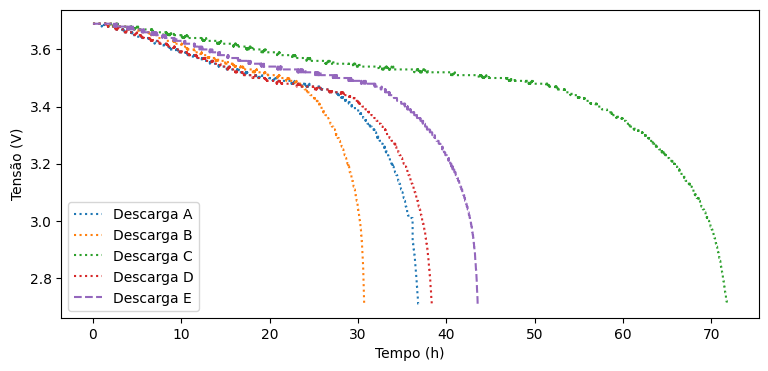

In [10]:
plt.rcParams['figure.figsize'] = (9, 4)
plt.plot(t_e1/(60*60),d_curve_e1, ls = ':', label='Descarga A')#DS18B20
plt.plot(t_e2/(60*60),d_curve_e2, ls = ':', label='Descarga B')#DS18B20 e Voltímetro
plt.plot(t_e4/(60*60),d_curve_e4, ls = ':', label='Descarga C')#Termopar I2C
plt.plot(t_e3/(60*60),d_curve_e3, ls = ':', label='Descarga D')#Voltímetro
plt.plot(t_e5/(60*60),d_curve_e5, ls = '--', label='Descarga E')#Termopar I2C e INA219

plt.legend(loc='lower left')
#plt.title('Curvas de Descarga')
plt.xlabel('Tempo (h)')
plt.ylabel('Tensão (V)')
plt.show()

Função que gera instâncias a partir de um número de pontos (tamantnho do segmento observado):

In [11]:
def gen_dataset(curve, ts, pn):
  ll = len(curve)

  X = np.zeros((ll-pn, pn))
  Y = np.zeros(ll-pn)

  for i in range(ll-pn):
    for j in range(pn):
      X[i][pn-j-1] = curve[pn+i-j-1]


  Y = ts[pn:]
  Y = max(Y) - Y

  return (X,Y)

Outras funções pertinentes (normalização, reescalagem)

In [12]:
def norm(v, mi, ma):
  n_v = (v-mi)/(ma-mi)

  return n_v

In [13]:
def de_norm(n_v, mi, ma):
  v = ((n_v)*(ma-mi))+mi

  return v

Limiares da normalização dos dados:

In [14]:
X_min = 2.70 
X_max = 3.70 

print('Limite mínimo da tensão para normalização: ', X_min * 1000, 'mV')
print('Limite máximo da tensão para normalização: ', X_max * 1000, 'mV')

Y_min = min(np.concatenate((t_e1,t_e2,t_e3,t_e4,t_e5)))
Y_max = max(np.concatenate((t_e1,t_e2,t_e3,t_e4,t_e5)))

print('\nLimite mínimo do tempo para normalização: ', Y_min, 's')
print('Limite máximo do tempo para normalização: ', Y_max, 's')

Limite mínimo da tensão para normalização:  2700.0 mV
Limite máximo da tensão para normalização:  3700.0 mV

Limite mínimo do tempo para normalização:  0 s
Limite máximo do tempo para normalização:  258393 s


Número de épocas de treinamento do modelo:

In [15]:
ep = 10

# Implementação da Otimização Multiobjetivo

Inicialização do ambiente GPU:

In [16]:
print("N. GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))

N. GPUs Disponíveis:  1


In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

Função para geração de Datasets de treino e teste baseados em um dado tamanho da janela de observação (número de neurônios de entrada):

In [18]:
def redmis_dataset(ne):
  
    d1 = gen_dataset(norm(d_curve_e1, X_min, X_max), norm(t_e1, Y_min, Y_max), ne) #curva de descarga A
    d2 = gen_dataset(norm(d_curve_e3, X_min, X_max), norm(t_e3, Y_min, Y_max), ne) #curva de descarga B
    d3 = gen_dataset(norm(d_curve_e2, X_min, X_max), norm(t_e2, Y_min, Y_max), ne) #curva de descarga C
    d4 = gen_dataset(norm(d_curve_e4, X_min, X_max), norm(t_e4, Y_min, Y_max), ne) #curva de descarga D
    d5 = gen_dataset(norm(d_curve_e5, X_min, X_max), norm(t_e5, Y_min, Y_max), ne) #curva de descarga E
    
    #20% dos dados para validação
    d1Xf, d1Xv, d1Yf, d1Yv = train_test_split(d1[0], d1[1], test_size=0.2, random_state=6)
    d2Xf, d2Xv, d2Yf, d2Yv = train_test_split(d2[0], d2[1], test_size=0.2, random_state=6)
    d3Xf, d3Xv, d3Yf, d3Yv = train_test_split(d3[0], d3[1], test_size=0.2, random_state=6) 
    d4Xf, d4Xv, d4Yf, d4Yv = train_test_split(d4[0], d4[1], test_size=0.2, random_state=6) 
    
    #Treino: Descargas A, B, C e D (80%)
    X_treino = pd.DataFrame(np.concatenate((d1Xf, d2Xf, d3Xf, d4Xf)))
    Y_treino = pd.DataFrame(np.concatenate((d1Yf, d2Yf, d3Yf, d4Yf)))
    
    #Validação: Descargas A, B, C e D (20%)
    X_val = pd.DataFrame(np.concatenate((d1Xv, d2Xv, d3Xv, d4Xv)))
    Y_val = pd.DataFrame(np.concatenate((d1Yv, d2Yv, d3Yv, d4Yv)))

    #Teste: Descargas E
    X_teste = pd.DataFrame(d5[0])
    Y_teste = pd.DataFrame(d5[1])

    return X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val

Função para avaliação de um indivíduo. Um indivíduo consiste em um combinação de:

- Número de neurônios da camada de entrada (n_entrada)
- Número de neurônios na camada CNN (n_cnn)
- Número de neurônios da camada LSTM (n_lstm)

In [19]:
def evaluate_ind(individual):
    n_cnn, n_lstm, n_entrada = individual

    with tf.device('/GPU:0'):
      model = keras.models.Sequential()
      model.add(keras.layers.Reshape((n_entrada, 1), input_shape=(n_entrada,)))

      #1st layer - CNN
      model.add(keras.layers.Conv1D(n_cnn, 3, activation='relu'))
      model.add(keras.layers.MaxPooling1D(2))

      #2nd layer - LSTM
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Reshape((int((n_entrada-2)/2), n_cnn)))
      model.add(keras.layers.LSTM(n_lstm, activation='tanh'))

      #Output layer
      model.add(keras.layers.Dense(1, activation='sigmoid'))

      model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mse'])
      Xf, Yf, Xt, Yt, Xv, Yv = redmis_dataset(n_entrada)    
      
      h = model.fit(Xf, Yf, epochs=ep, batch_size=64, verbose=0, validation_data=(Xv, Yv))

      eval_mse = model.evaluate(Xt, Yt, verbose=0) 

      keras.backend.clear_session()

    return eval_mse[1], n_entrada


Função para avaliar uma populaçao composta de indivíduos:

In [20]:
def evaluate_pop(population):
    n_cnn, n_lstm, n_entrada = population

    mse_fitness = []
    ne_fitness = []
    for n in range(len(n_cnn)):
        mse, ne = evaluate_ind((n_cnn[n], n_lstm[n], n_entrada[n]))
        mse_fitness.append(mse)
        ne_fitness.append(ne)

    return np.array(mse_fitness), np.array(ne_fitness)

Definição da classe do problema a ser otimizado:

In [21]:
class targetProblem(Problem):
    def __init__(self):
      super().__init__(n_var=3, n_obj=2, n_constr=0, xl=[6, 6, 4], xu=[32, 32, 32], vtype=int)

    def _evaluate(self, x, out, *args, **kwargs):
        n_cnn = x[:,0]
        n_lstm = x[:,1]
        n_entrada = x[:,2]

        mse, _ = evaluate_pop((n_cnn, n_lstm, n_entrada))
        out["F"] = [mse, n_entrada]

Implementação do algoritmo NSGA2 no problema definido:

In [22]:
ps = 20
problem = targetProblem()
algorithm = NSGA2(
    pop_size=ps,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.7, eta=20, vtype=float, repair=RoundingRepair()),
    mutation=PolynomialMutation(prob=0.2, eta=20, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True
)

print('\n\nNSGA-II inicializado - tamanho da população: ', ps)
res = minimize(problem, algorithm, ('n_gen', 20), verbose=True, save_history=True, seed=6)

best_top = res.X
best_sol = res.F



NSGA-II inicializado - tamanho da população:  20


I0000 00:00:1707279179.736571      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |      5 |  0.0769230769 |         ideal
     3 |       60 |      5 |  0.0261846951 |             f
     4 |       80 |      4 |  0.1251542455 |         nadir
     5 |      100 |      3 |  0.0638511534 |             f
     6 |      120 |      3 |  0.0111181662 |             f
     7 |      140 |      3 |  0.000000E+00 |             f
     8 |      160 |      3 |  0.0039895929 |             f
     9 |      180 |      3 |  0.0025824689 |         ideal
    10 |      200 |      3 |  0.0330489078 |         ideal
    11 |      220 |      3 |  0.0373463413 |         nadir
    12 |      240 |      3 |  0.000000E+00 |             f
    13 |      260 |      3 |  0.000000E+00 |             f
    14 |      280 |      3 |  0.000000E+00 |             f
    15 |      300 |      3 |  0.000000E+00 |             f
    16 |      320 |      3 |  0.000000E+00 |            

# Visualização

Plot das soluções não dominadas:

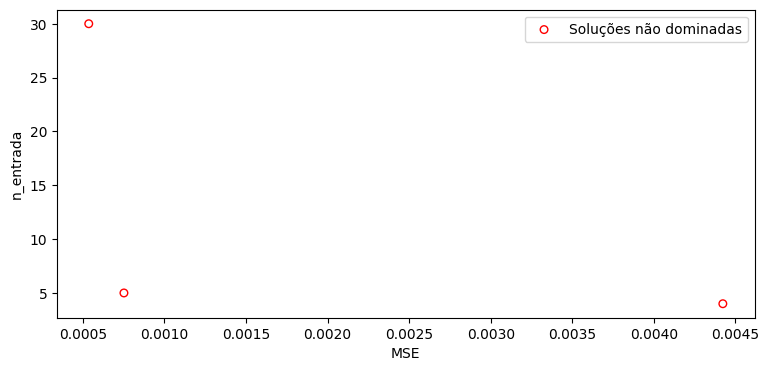

In [23]:
f1 = res.F[:,0]
f2 = res.F[:,1]
plt.scatter(f1,f2, s=30, facecolors='none', edgecolors='red', label=('Soluções não dominadas'))
plt.xlabel("MSE")
plt.ylabel("n_entrada")
plt.legend()
plt.show()

Plot dos resultados ao longo das gerações:

In [24]:
all_pop = Population()

In [25]:
for algorithm in res.history:
 all_pop = Population.merge(all_pop, algorithm.off)
df_Var = pd.DataFrame(all_pop.get("X"), columns=[f"X{i+1}" for i in
range(problem.n_var)])
df_Res = pd.DataFrame(all_pop.get("F"), columns=[f"F{i+1}" for i in
range(problem.n_obj)])

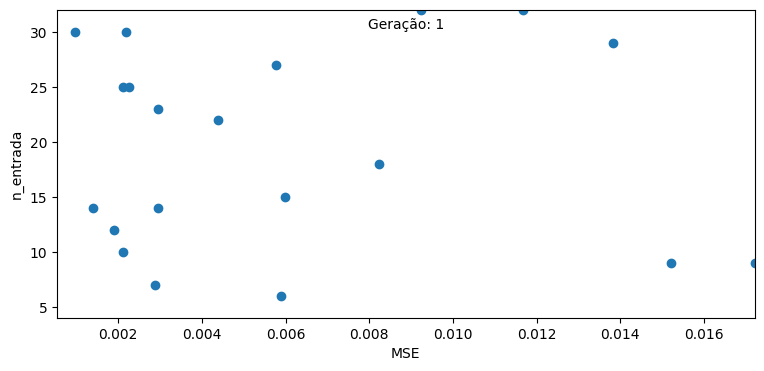

In [26]:
import matplotlib.animation as animation
from IPython.display import Image

df_Res['Modulo_F2'] = np.sqrt(df_Res['F2'] ** 2)

fig, ax = plt.subplots()
scatter = ax.scatter([], [], animated=True)
ax.set_xlim(df_Res['F1'].min(), df_Res['F1'].max())
ax.set_ylim(df_Res['Modulo_F2'].min(), df_Res['Modulo_F2'].max())
ax.set_xlabel('MSE')
ax.set_ylabel('n_entrada')

frame_counter = ax.text(0.5, 0.95, '', ha='center', va='center', transform=ax.transAxes)

def update(frame):
    start_index = frame * ps
    end_index = start_index + ps
    data = df_Res.iloc[start_index:end_index]
    scatter.set_offsets(data[['F1', 'Modulo_F2']])

    frame_counter.set_text(f'Geração: {frame + 1}')

    return scatter, frame_counter

total_frames = len(df_Res) // ps
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=600, blit=True)

plt.show()

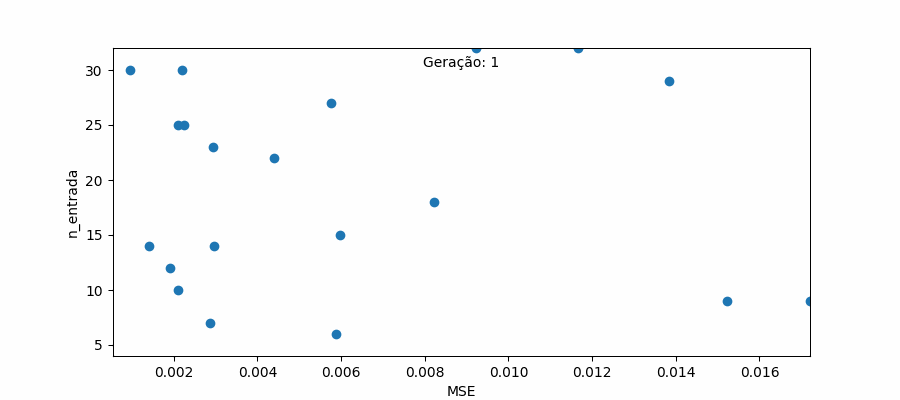

In [27]:
writer = animation.PillowWriter(fps=1, bitrate=1800)
ani.save('scatter.gif', writer=writer)
Image(open('scatter.gif','rb').read())

Visualização das melhores topologias e geração das imagens dos modelos:

In [28]:
for i in range(len(best_top)):
    
    name = 'Modelo_' + str(i+1)    
    print(name)
    print('Topologia: ')    
    
    n_entrada = int(best_top[i][2])
    n_cnn = int(best_top[i][0])
    n_lstm = int(best_top[i][1])    
    
    tmodel = keras.models.Sequential()
    tmodel.add(keras.layers.Reshape((n_entrada, 1), input_shape=(n_entrada,)))

    #1st layer - CNN
    tmodel.add(keras.layers.Conv1D(n_cnn, 3, activation='relu'))
    tmodel.add(keras.layers.MaxPooling1D(2))

    #2nd layer - LSTM
    tmodel.add(keras.layers.Flatten())
    tmodel.add(keras.layers.Reshape((int((n_entrada-2)/2), n_cnn)))
    tmodel.add(keras.layers.LSTM(n_lstm, activation='tanh'))

    #Output layer
    tmodel.add(keras.layers.Dense(1, activation='sigmoid'))
    
    print('N. neurônios da camada de entrada: ', n_entrada)
    print('N. neurônios da camada CNN: ', n_cnn)
    print('N. neurônios da camada LSTM: ', n_lstm)
    print('MSE no conjunto de teste: ', best_sol[i][0])
    
    plot_model(tmodel, to_file= str(name + '_plot.png'), show_shapes=True, show_layer_names=True)
    
    print('\n\n')    
    

Modelo_1
Topologia: 
N. neurônios da camada de entrada:  30
N. neurônios da camada CNN:  17
N. neurônios da camada LSTM:  32
MSE no conjunto de teste:  0.0005357632180675864



Modelo_2
Topologia: 
N. neurônios da camada de entrada:  4
N. neurônios da camada CNN:  14
N. neurônios da camada LSTM:  26
MSE no conjunto de teste:  0.004422813653945923



Modelo_3
Topologia: 
N. neurônios da camada de entrada:  5
N. neurônios da camada CNN:  31
N. neurônios da camada LSTM:  31
MSE no conjunto de teste:  0.0007514497265219688





In [29]:
print("Tempo de execução total: %s segundos " % (time.time() - start_time))

Tempo de execução total: 3596.313062429428 segundos 
